## Auswertung Zisterne Datenfiles
Datenfiles aus Zisternen-Controller auswerten

Remarks:<br>
11.05.19 Filterreinigung<br>
21.05.19 Anpassung Filterüberlauf von 203cm auf 183cm

### Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from sklearn import preprocessing
import os
import requests
from IPython.display import IFrame
import datetime
import re
from sklearn import tree

### Daten einlesen

In [2]:
# Datensammlung einlesen
df1=pd.read_csv('Datensammlung.csv',engine='python',sep=';',decimal=',',index_col=False)
df1['Timestamp']=pd.to_datetime(df1['Date'],format='%d.%m.%Y %H:%M')
#Umbenennung falsche Spaltennamen
df1=df1.rename(columns={"Measured quantity change 24h [Liter]": "Measured quantity change 1h [Liter]", "Calculated quantity change 24h [Liter]": "Calculated quantity change 1h [Liter]", "Refill quantity 24h [Liter]":"Refill quantity 1h [Liter]"})
df1.tail()

,Log File,Date,Level [mm],Quantity [Liter],Signal health [-],Error [-],StdDev [Liter],Refill Quantity [Liter],Rain quantity 24h [Liter],Refill quantity 1h [Liter],Measured quantity change 1h [Liter],Calculated quantity change 1h [Liter],Quantity difference [%],Filter diagnosis [-],Usage in last 24h [Liter],Usage average in last 10d [Liter],Timestamp
629,181203_V310_4.csv,03.12.2018 16:17,1097,3446,98,Kein Fehler erkannt,1.51,180,14.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-03 16:17:00
630,181203_V310_4.csv,03.12.2018 17:17,1136,3568,100,Kein Fehler erkannt,0.00,180,16.23,0.0,122.0,156.0,21.0,Verstopft,NaN,NaN,2018-12-03 17:17:00
631,181203_V310_4.csv,03.12.2018 18:17,1221,3835,98,Kein Fehler erkannt,1.81,180,18.00,0.0,267.0,157.0,0.0,OK,NaN,NaN,2018-12-03 18:17:00
632,181203_V310_4.csv,03.12.2018 19:17,1330,4178,100,Kein Fehler erkannt,0.00,180,20.65,0.0,343.0,244.0,0.0,OK,NaN,NaN,2018-12-03 19:17:00
633,181203_V310_4.csv,03.12.2018 20:17,1437,4514,100,Kein Fehler erkannt,0.00,180,22.72,0.0,336.0,186.0,0.0,OK,NaN,NaN,2018-12-03 20:17:00


### Weitere Daten lesen ab 3.12.18
Alle Daten befinden sich im unterverzeichnis ./csv. Die obigen Daten stehen im ./bak verzeichnis

In [3]:
# Aktuelle Web-Page darstellen 
IFrame(src='http://192.168.178.5', width=700, height=800)

Erst mal neue Daten lesen

In [4]:
# Programm Version bestimmen 
#<H2>Programminfo</h2><p>V3.1.0</p>
response = requests.get('http://192.168.178.5')
base_text = response.text
base_text=base_text.replace('\n','')
base_text=base_text.replace('\r','')
#x = re.match('.*<H2>Programminfo</h2><p>(\S*)</p>.*', base_text) 
x = re.search('(?<=<H2>Programminfo</h2><p>)(\S+)(?=</p>)', base_text) 
version=x.group(0)
version=version.replace('.','')

# Get data log file
response = requests.get('http://192.168.178.5/Res_Ctl.csv')
data = response.text
data=data.replace('\r\r','\r')
if (len(re.findall('\r\n',data))>1):
    filename="csv/"+datetime.datetime.now().strftime("%y%m%d%H%M%S")+"_"+version+".csv"
    text_file = open(filename, "w")
    text_file.write("%s" % data)
    text_file.close()
    print("New file saved: "+filename)
else:
    print("Received file is empty and will not be saved")
    
# Get system log file
response = requests.get('http://192.168.178.5/Res_Ctl.log')
data = response.text
data=data.replace('\r\r','\r')
if (len(re.findall('\r\n',data))>1):
    filename="log/"+datetime.datetime.now().strftime("%y%m%d%H%M%S")+"_"+version+".log"
    text_file = open(filename, "w")
    text_file.write("%s" % data)
    text_file.close()
    print("New file saved: "+filename)
else:
    print("Received file is empty and will not be saved")    

    

New file saved: csv/191128141021_V423.csv
New file saved: log/191128141143_V423.log


In [5]:
# Dateien listen
newfiles=os.listdir('./csv')
#newfiles

In [6]:
#Dataframe mit allen Daten erstellen
df=df1
for nFile in newfiles:
    df2=pd.read_csv('./csv/'+nFile,engine='python',sep=';',decimal='.',index_col=False)    
    df2=df2.rename(columns={"Measured quantity change 24h [Liter]": "Measured quantity change 1h [Liter]", "Calculated quantity change 24h [Liter]": "Calculated quantity change 1h [Liter]", "Refill quantity 24h [Liter]":"Refill quantity 1h [Liter]"})
    df2.insert(0,'Log File',nFile)
    df2['Timestamp']=pd.to_datetime(df2['Date'],format='%Y-%m-%d %H:%M:%S')
    df=df.append(df2,sort=False)
df.tail()

,Log File,Date,Level [mm],Quantity [Liter],Signal health [-],Error [-],StdDev [Liter],Refill Quantity [Liter],Rain quantity 24h [Liter],Refill quantity 1h [Liter],Measured quantity change 1h [Liter],Calculated quantity change 1h [Liter],Quantity difference [%],Filter diagnosis [-],Usage in last 24h [Liter],Usage average in last 10d [Liter],Timestamp
329,191128141021_V423.csv,2019-11-28 09:42:28,1271,3992,1,Fehler erkannt,0.0,6000,746.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-11-28 09:42:28
330,191128141021_V423.csv,2019-11-28 10:42:37,1271,3992,1,Fehler erkannt,0.0,6000,746.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-11-28 10:42:37
331,191128141021_V423.csv,2019-11-28 11:42:45,1271,3992,1,Fehler erkannt,0.0,6000,747.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-11-28 11:42:45
332,191128141021_V423.csv,2019-11-28 12:42:53,1271,3992,1,Fehler erkannt,0.0,6000,747.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-11-28 12:42:53
333,191128141021_V423.csv,2019-11-28 13:43:02,1271,3992,1,Fehler erkannt,0.0,6000,747.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-11-28 13:43:02


In [7]:
df.describe()

,Level [mm],Quantity [Liter],Signal health [-],StdDev [Liter],Refill Quantity [Liter],Rain quantity 24h [Liter],Refill quantity 1h [Liter],Measured quantity change 1h [Liter],Calculated quantity change 1h [Liter],Quantity difference [%],Usage in last 24h [Liter],Usage average in last 10d [Liter]
count,9148.000000,9148.000000,9148.000000,9148.000000,9148.000000,8687.000000,133.000000,133.000000,133.000000,133.000000,63.00000,63.000000
mean,1146.321819,3600.787057,98.205400,1.196223,3103.233494,230.181566,2.556391,138.909774,207.932331,34.699248,137.31746,122.317460
std,609.623330,1915.192212,5.856498,2.078558,2661.479320,273.295441,22.884894,110.773757,118.929391,37.773244,131.95146,93.562955
min,0.000000,0.000000,1.000000,0.000000,0.000000,-1.000000,0.000000,-198.000000,89.000000,0.000000,-36.00000,18.000000
25%,447.000000,1404.000000,98.000000,0.000000,60.000000,0.300000,0.000000,73.000000,126.000000,0.000000,44.50000,64.500000
50%,1380.500000,4336.500000,99.000000,0.620000,4720.000000,70.800000,0.000000,117.000000,180.000000,28.000000,87.00000,83.000000
75%,1706.000000,5359.000000,100.000000,1.490000,5940.000000,533.400000,0.000000,173.000000,250.000000,63.000000,255.50000,135.500000
max,1885.000000,5921.000000,100.000000,94.370000,6000.000000,747.200000,260.000000,549.000000,825.000000,224.000000,445.00000,330.000000


In [8]:
# Rohdaten abspeichern als xls
df.to_excel('../log/data_collection_raw.xlsx')

### Vorverarbeitung

In [9]:
# Daten mit 1.1.70 entfernen
df=df[(df['Timestamp']>'1970-01-01 12:00:00')]

# Datum als Index setzen
df.set_index('Timestamp',inplace=True,drop=False)

# Strings durch Zahlen ersetzen: Filterdiagnose
#df['Filter diagnosis [-]']=df['Filter diagnosis [-]'].replace('OK',1)
#df['Filter diagnosis [-]']=df['Filter diagnosis [-]'].replace('Verstopft',0)


In [10]:
# Replace Rain quantity 24h from 1.5.19 (Homematic IP delivers total rain counter instead of 24h value)
dt=df['Timestamp'].astype('int64').diff(24)/(1e9*60*60*24)
df["Rain quantity total [Liter]"]=df["Rain quantity 24h [Liter]"];
RQ24corr=df["Rain quantity total [Liter]"].where((df['Timestamp']>'2019-04-15 00:00:00') & (df["Rain quantity total [Liter]"]>0)).diff(24).clip(0,10000)/dt;
df["Rain quantity 24h [Liter]"] = RQ24corr



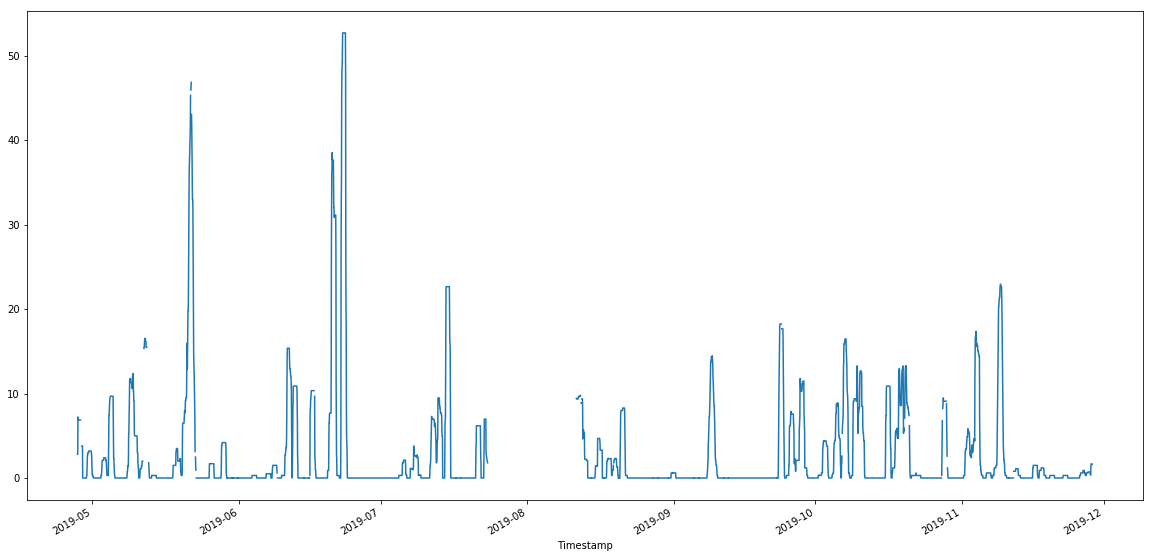

In [11]:
plt.figure(figsize=(20,10))
df["Rain quantity 24h [Liter]"] .plot()
#df["Rain quantity total [Liter]"].plot()

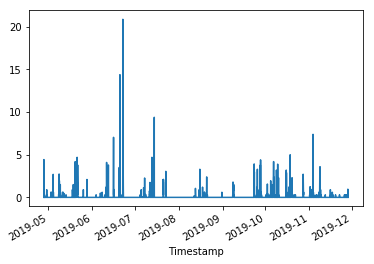

In [12]:
df['Rain quantity 1h [Liter]']=df['Rain quantity 24h [Liter]'].diff()
df['Rain quantity 1h [Liter]']=df['Rain quantity 1h [Liter]'].clip(0,100)
df['Rain quantity 1h [Liter]']=df['Rain quantity 1h [Liter]'].replace(100,np.nan).interpolate()
df['Rain quantity 1h [Liter]'].plot()


In [13]:
#Korrigierte Daten abspeichern als xls
df.to_excel('../log/data_collection.xlsx')

### Datensatz zerlegen 
1. Grunddaten Pegel, Menge, Nachspeisung, Regen

In [28]:
# 1. Grunddaten
dfg=df.iloc[:,0:9]
dfg.tail(20)

,Log File,Date,Level [mm],Quantity [Liter],Signal health [-],Error [-],StdDev [Liter],Refill Quantity [Liter],Rain quantity 24h [Liter]
Timestamp,,,,,,,,,
2019-11-27 18:40:23,191128141021_V423.csv,2019-11-27 18:40:23,1271,3992,1,Fehler erkannt,0.0,6000,0.718344
2019-11-27 19:40:32,191128141021_V423.csv,2019-11-27 19:40:32,1271,3992,1,Fehler erkannt,0.0,6000,0.718334
2019-11-27 20:40:40,191128141021_V423.csv,2019-11-27 20:40:40,1271,3992,1,Fehler erkannt,0.0,6000,0.718344
2019-11-27 21:40:48,191128141021_V423.csv,2019-11-27 21:40:48,1271,3992,1,Fehler erkannt,0.0,6000,0.718354
2019-11-27 22:40:57,191128141021_V423.csv,2019-11-27 22:40:57,1271,3992,1,Fehler erkannt,0.0,6000,0.718334
2019-11-27 23:41:05,191128141021_V423.csv,2019-11-27 23:41:05,1271,3992,1,Fehler erkannt,0.0,6000,0.718344
2019-11-28 00:41:13,191128141021_V423.csv,2019-11-28 00:41:13,1271,3992,1,Fehler erkannt,0.0,6000,0.718344
2019-11-28 01:41:22,191128141021_V423.csv,2019-11-28 01:41:22,1271,3992,1,Fehler erkannt,0.0,6000,0.718334
2019-11-28 02:41:30,191128141021_V423.csv,2019-11-28 02:41:30,1271,3992,1,Fehler erkannt,0.0,6000,0.718344


2. Filter-Diagnosedaten

In [15]:
# 2. Filter-Diagnosedaten
# Werte auswaehlen
dfd=df.iloc[:, 1:14]
dfd['Rain quantity 1h [Liter]']=df['Rain quantity 1h [Liter]']
dfd_failed=dfd.where(dfd['Filter diagnosis [-]']==0).dropna(axis=0,how='all')
dfd_ok = dfd.where(dfd['Filter diagnosis [-]']==1).dropna(axis=0,how='all')
dfd_all=pd.concat([dfd_failed, dfd_ok])
dfd_all.sort_values('Timestamp')
dfd_all.tail(20)

,Date,Level [mm],Quantity [Liter],Signal health [-],Error [-],StdDev [Liter],Refill Quantity [Liter],Rain quantity 24h [Liter],Refill quantity 1h [Liter],Measured quantity change 1h [Liter],Calculated quantity change 1h [Liter],Quantity difference [%],Filter diagnosis [-],Rain quantity 1h [Liter]
Timestamp,,,,,,,,,,,,,,


3. Verbrauchsberechnung

In [16]:
# 3. Verbrauchsdaten
dfv=df.iloc[:,14:16]

#Werte kleiner Null abschneiden (SW-Fehler)
dfv['Usage in last 24h [Liter]']=dfv['Usage in last 24h [Liter]'].clip(lower=0)
dfv['Usage average in last 10d [Liter]']=dfv['Usage average in last 10d [Liter]'].clip(lower=0)
dfv=dfv.where(dfv['Usage in last 24h [Liter]']>0)
# NaNs entfernen
dfv=dfv.dropna(axis=0,how='any')
dfv.tail()

,Usage in last 24h [Liter],Usage average in last 10d [Liter]
Timestamp,,
2019-04-08 02:02:12,348.0,322.0
2019-04-09 02:05:28,285.0,329.0
2019-04-10 02:08:45,266.0,330.0
2019-04-11 02:12:01,60.0,291.0
2019-04-13 02:18:32,312.0,283.0


### Pegeldaten analysieren

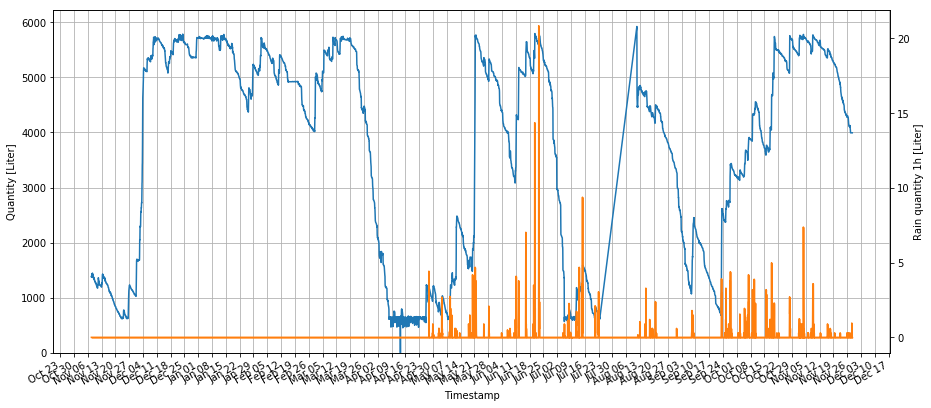

In [17]:
#plot data
fig, ax = plt.subplots(figsize=(15,7))
df['Quantity [Liter]'].plot(ax=ax,grid=True)
df['Rain quantity 1h [Liter]'].plot(ax=ax,grid=True,secondary_y=True,kind='area')

#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.set_ylabel('Quantity [Liter]')
plt.ylabel('Rain quantity 1h [Liter]');


### Filter-Diagnose analysieren

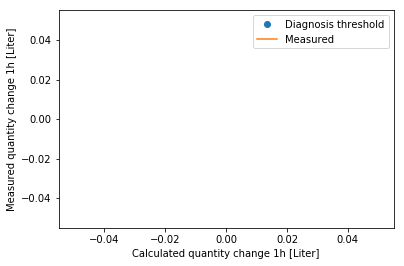

In [18]:
plt.plot(dfd_all['Calculated quantity change 1h [Liter]'],dfd_all['Measured quantity change 1h [Liter]'],'o')
plt.plot(dfd_all['Calculated quantity change 1h [Liter]'],0.8*dfd_all['Calculated quantity change 1h [Liter]'])
plt.xlabel('Calculated quantity change 1h [Liter]')
plt.ylabel('Measured quantity change 1h [Liter]')
plt.legend({'Measured','Diagnosis threshold'});

### Fehlerhafte Datenpunkte
Filterverstopfung angezeigt aber tatsächlich nicht verstopft

In [19]:
numPntsOK = dfd_ok.Date.count()
numPntsFailed = dfd_failed.Date.count()
numPntsTot=numPntsFailed+numPntsOK
print("Korrekt erkannte OK-Fälle   : ", numPntsOK, " (", 100*numPntsOK/numPntsTot, "%)")
print("Fehlerhaft erkannte OK-Fälle: ", numPntsFailed, " (", 100*numPntsFailed/numPntsTot, "%)")


Korrekt erkannte OK-Fälle   :  0  ( nan %)
Fehlerhaft erkannte OK-Fälle:  0  ( nan %)


C:\Users\Andreas\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in long_scalars
  after removing the cwd from sys.path.
C:\Users\Andreas\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """


In [20]:
dfd_failed.head(20)
#Manuelle Analyse: 
#2018-12-22 20:44:12 Speicher voll aber Diagnose noch aktiv --> behoben in SW durch größeres Band 
#2018-12-22 06:03:12 Speicher voll aber Diagnose noch aktiv --> behoben in SW durch größeres Band 
#2018-12-21 08:00:18 Speicher voll aber Diagnose noch aktiv --> behoben in SW durch größeres Band 
#2018-12-02 19:14:00 geringe Überschreitung
#2018-12-02 21:14:00 geringe Überschreitung, Starkregen
#2018-12-03 17:17:00 geringe Überschreitung
#2018-12-03 21:18:06 Starkregen
#2019-02-10 17:03:22 Starkregen

,Date,Level [mm],Quantity [Liter],Signal health [-],Error [-],StdDev [Liter],Refill Quantity [Liter],Rain quantity 24h [Liter],Refill quantity 1h [Liter],Measured quantity change 1h [Liter],Calculated quantity change 1h [Liter],Quantity difference [%],Filter diagnosis [-],Rain quantity 1h [Liter]
Timestamp,,,,,,,,,,,,,,


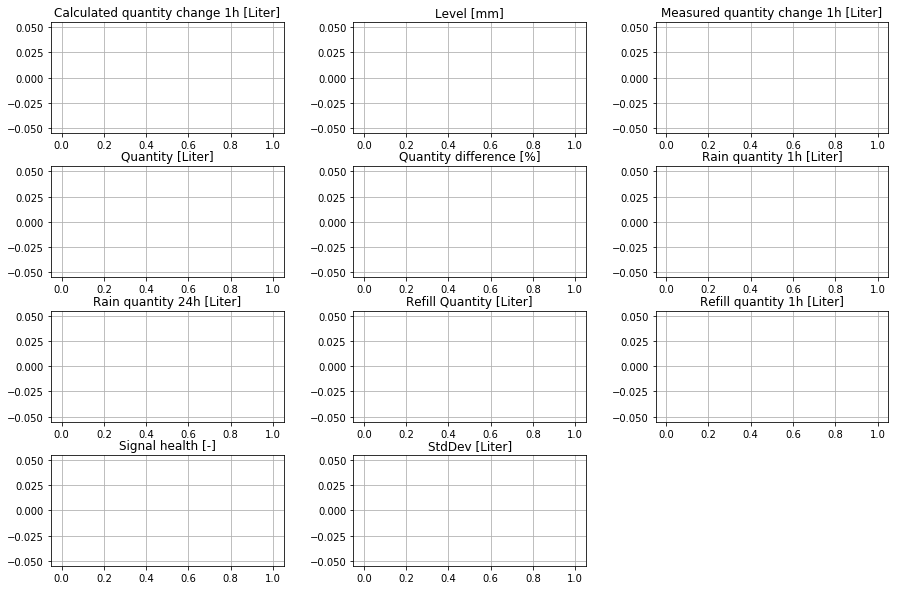

In [21]:
dfd_failed.hist(figsize=[15, 10]);

In [22]:
#dfd_ok.tail()

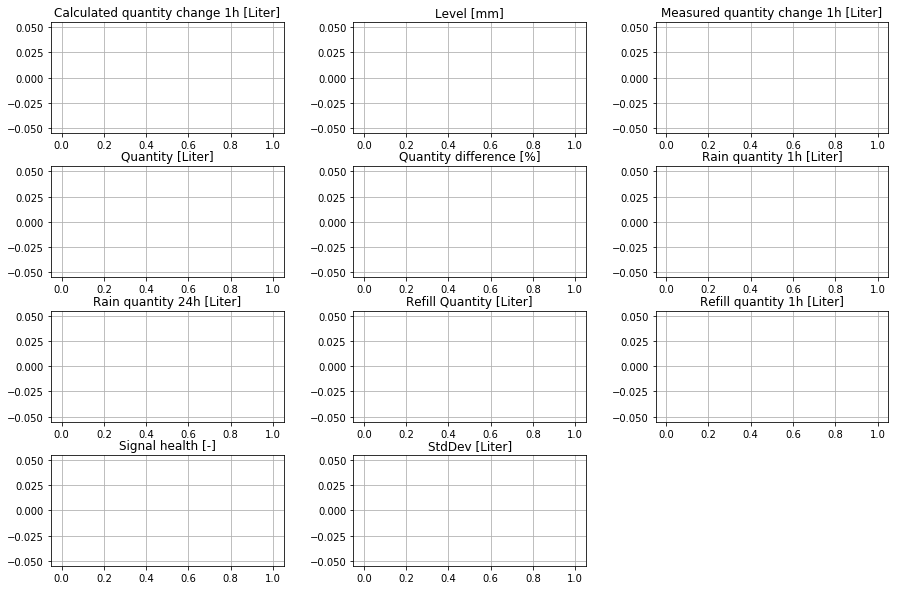

In [23]:
dfd_ok.hist(figsize=[15, 10]);

### Aufsummierte Regenmenge

### Filtereffizienz

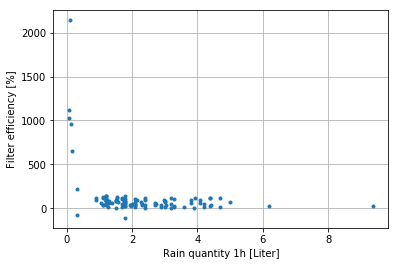

In [24]:
aRoof = 100
dfd["rEffFlt [%]"] = 100*(dfd["Measured quantity change 1h [Liter]"]/(dfd["Rain quantity 1h [Liter]"]*aRoof))
plt.plot(dfd["Rain quantity 1h [Liter]"],dfd["rEffFlt [%]"],'.');
plt.xlabel('Rain quantity 1h [Liter]')
plt.ylabel('Filter efficiency [%]')
plt.grid()

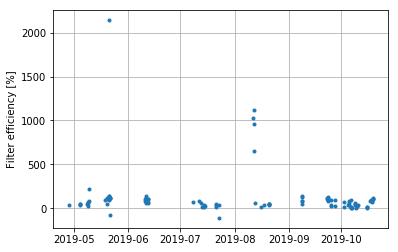

In [25]:
plt.plot(dfd["rEffFlt [%]"],'.');

plt.ylabel('Filter efficiency [%]')
plt.grid()

In [26]:
dfd_all=dfd.dropna(axis=0,how='any')
dfd_all.tail(20)

,Date,Level [mm],Quantity [Liter],Signal health [-],Error [-],StdDev [Liter],Refill Quantity [Liter],Rain quantity 24h [Liter],Refill quantity 1h [Liter],Measured quantity change 1h [Liter],Calculated quantity change 1h [Liter],Quantity difference [%],Filter diagnosis [-],Rain quantity 1h [Liter],rEffFlt [%]
Timestamp,,,,,,,,,,,,,,,
2019-10-06 21:52:15,2019-10-06 21:52:15,1203,3779,100,Kein Fehler erkannt,0.00,5980,9.078984,0.0,32.0,149.0,78.0,Verstopft,1.696244,18.865206
2019-10-06 22:52:24,2019-10-06 22:52:24,1216,3820,98,Kein Fehler erkannt,1.09,5980,13.269131,0.0,41.0,400.0,89.0,Verstopft,4.190147,9.784860
2019-10-07 00:52:41,2019-10-07 00:52:41,1238,3889,100,Kein Fehler erkannt,0.00,5980,15.863096,0.0,19.0,220.0,91.0,Verstopft,2.394274,7.935599
2019-10-08 21:58:58,2019-10-08 21:58:58,1247,3917,100,Kein Fehler erkannt,0.00,5980,2.394402,0.0,75.0,190.0,60.0,Verstopft,2.095098,35.797843
2019-10-08 22:59:05,2019-10-08 22:59:05,1300,4084,100,Kein Fehler erkannt,0.00,5980,5.587067,0.0,167.0,299.0,44.0,Verstopft,3.192665,52.307398
2019-10-08 23:59:13,2019-10-08 23:59:13,1352,4247,99,Kein Fehler erkannt,0.44,5980,8.280831,0.0,163.0,250.0,34.0,Verstopft,2.693764,60.510117
2019-10-09 20:02:00,2019-10-09 20:02:00,1379,4332,98,Kein Fehler erkannt,1.09,5980,13.269284,0.0,16.0,369.0,95.0,Verstopft,3.891210,4.111832
2019-10-10 01:02:42,2019-10-10 01:02:42,1393,4376,100,Kein Fehler erkannt,0.00,5980,7.083603,0.0,41.0,240.0,82.0,Verstopft,1.795965,22.828952
2019-10-10 09:03:50,2019-10-10 09:03:50,1426,4479,98,Kein Fehler erkannt,1.49,5980,10.076558,0.0,56.0,159.0,64.0,Verstopft,1.795918,31.181827


In [27]:
dfd["rEffFlt [%]"].plot(kind='hist')

ValueError: autodetected range of [-110.25208333333264, inf] is not finite

### Verbrauchsberechnung

In [ ]:
dfv.tail(10)

In [ ]:
dfv.describe()

In [ ]:
dfv.hist();

In [ ]:
#plot data
fig, ax = plt.subplots(figsize=(15,7))
dfv.plot(ax=ax,grid=True,style='.-')

#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
